In [1]:
!pip install -U torch==2.3.1 # requires torch 2.1.1+ (for efficient sdpa implementation)
!pip install PyMuPDF # for reading PDFs with Python
!pip install tqdm # for progress bars
!pip install -U sentence-transformers # for embedding models
!pip install accelerate # for quantization model loading
!pip install bitsandbytes # for quantizing models (less storage space)
!pip install flash-attn --no-build-isolation # for faster attention mechanism = faster LLM inference
!pip install -U transformers

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

1. Document/Text Processing and Embedding Creation

Import PDF Document

In [2]:
import os
import requests

pdf_path = "human-nutrition-text.pdf"

if not os.path.exists(pdf_path):
    print("File doesn't exist, downloading...")

    url = "https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf"

    filename = pdf_path

    response = requests.get(url)

    if response.status_code == 200:
      with open(filename, 'wb') as file:
          file.write(response.content)
      print("File downloaded successfully.")
    else:
        print("Failed to download the file.")
else:
    print("File already exists.")

File doesn't exist, downloading...
File downloaded successfully.


In [3]:
import fitz
doc = fitz.open(pdf_path)
len(doc)

1208

In [4]:
import fitz
from tqdm.auto import tqdm

def text_formatter(text:str) -> str:
  cleaned_text = text.replace("\n", " ").strip()
  return cleaned_text

def open_and_read_pdf(pdf_path:str) -> list[dict]:
  doc = fitz.open(pdf_path)
  pages_and_texts = []

  for page_number, page in tqdm(enumerate(doc)):
    text = page.get_text()
    text = text_formatter(text)
    pages_and_texts.append({"page_number": page_number - 41,
                            "page_char_count": len(text),
                            "page_word_count": len(text.split(" ")),
                            "page_sentence_count_raw": len(text.split(".")),
                            "page_token_count": len(text) / 4,
                            "text": text})

  return pages_and_texts

pages_and_texts = open_and_read_pdf(pdf_path)
pages_and_texts[:2]

0it [00:00, ?it/s]

[{'page_number': -41,
  'page_char_count': 29,
  'page_word_count': 4,
  'page_sentence_count_raw': 1,
  'page_token_count': 7.25,
  'text': 'Human Nutrition: 2020 Edition'},
 {'page_number': -40,
  'page_char_count': 0,
  'page_word_count': 1,
  'page_sentence_count_raw': 1,
  'page_token_count': 0.0,
  'text': ''}]

In [5]:
import random
random.sample(pages_and_texts, k=3)

[{'page_number': 1139,
  'page_char_count': 1388,
  'page_word_count': 223,
  'page_sentence_count_raw': 31,
  'page_token_count': 347.0,
  'text': 'in the United States.11 The program provides Electronic Benefit  Transfers (EBT) which work similarly to a debit card. Clients receive  a card with a certain allocation of money for each month that can be  used only for food. In 2010, the average benefit was about $134 per  person, per month and total federal expenditures for the program  were $68.2 billion.12  The Special, Supplemental Program for Women,  Infants, and Children  The Special, Supplemental Program for Women, Infants and  Children  (WIC)  provides  food  packages  to  pregnant  and  breastfeeding women, as well as to infants and children up to age  five, to promote adequate intake for healthy growth and  development. Most state WIC programs provide vouchers that  participants use to acquire supplemental packages at authorized  stores. In 2010, WIC served approximately 9.2 mil

Get some stats on the text

In [6]:
import pandas as pd
df = pd.DataFrame(pages_and_texts)
df.head()

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,3,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,3,199.25,Contents Preface University of Hawai‘i at Mā...


Further text processing (splitting pages into sentences)

In [7]:
from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

doc = nlp("This is a sentence. This is another sentence.")
assert len(list(doc.sents)) == 2

list(doc.sents)

[This is a sentence., This is another sentence.]

In [8]:
for item in tqdm(pages_and_texts):
  item["sentences"] = list(nlp(item["text"]).sents)

  item["sentences"] = [str(sent) for sent in item["sentences"]]

  item["page_sentence_count_spacy"] = len(item["sentences"])

  0%|          | 0/1208 [00:00<?, ?it/s]

In [9]:
random.sample(pages_and_texts, k=1)

[{'page_number': -25,
  'page_char_count': 925,
  'page_word_count': 164,
  'page_sentence_count_raw': 3,
  'page_token_count': 231.25,
  'text': 'Chromium  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  686  Manganese  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  689  Molybdenum  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  692  Fluoride  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  695  Summary of Trace Minerals  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  700  Part\xa0XII.\xa0Chapter 12. Nutrition Applications  Introduction  University of Hawai‘i at Mānoa Food Science and  Human Nutrition Program and Human Nutrition  Program  707  Understanding Dietary Reference Intakes  University of Hawai‘i at Mān

Chunking our sentences together



In [10]:
num_sentence_chunk_size = 10

def split_list(input_list:list, slice_size:int) -> list[list[str]]:
  return [input_list[i:i+slice_size] for i in range(0, len(input_list), slice_size)]

for item in tqdm(pages_and_texts):
  item["sentence_chunks"] = split_list(input_list=item["sentences"],
                                       slice_size=num_sentence_chunk_size)

  item["num_chunks"] = len(item["sentence_chunks"])

  0%|          | 0/1208 [00:00<?, ?it/s]

Splitting each chunk into its own item



In [11]:
import re

pages_and_chunks = []
for item in tqdm(pages_and_texts):
  for sentence_chunk in item["sentence_chunks"]:
    chunk_dict = {}

    chunk_dict["page_number"] = item["page_number"]

    joined_sentence_chunk = "".join(sentence_chunk).replace("  ", " ").strip()
    joined_sentence_chunk = re.sub(r'\.([A-Z])', r'. \1', joined_sentence_chunk)
    chunk_dict["text"] = joined_sentence_chunk

    chunk_dict["chunk_char_count"] = len(joined_sentence_chunk)
    chunk_dict["chunk_word_count"] = len([word for word in joined_sentence_chunk.split(" ")])
    chunk_dict["chunk_token_count"] = len(joined_sentence_chunk) / 4

    pages_and_chunks.append(chunk_dict)

len(pages_and_chunks)

  0%|          | 0/1208 [00:00<?, ?it/s]

1843

In [12]:
random.sample(pages_and_chunks, k=1)

[{'page_number': 698,
  'text': '0.015 0.5 * Current AI used to determine Percent Daily Value Micronutrient Information Center: Fluoride. Oregon State University, Linus Pauling Institute. lpi.oregonstate.edu/mic/ minerals/fluoride . Updated in April 29, 2015. Accessed October 22, 2017. 698 | Fluoride',
  'chunk_char_count': 268,
  'chunk_word_count': 36,
  'chunk_token_count': 67.0}]

Embedding our text chunks

In [13]:
# !pip install torchvision==0.17.1

In [14]:
# !pip install sentence-transformers
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2")

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
sentences = [
    "The Sentences Transformers library provides an easy and open-source way to create embeddings.",
    "Sentences can be embedded one by one or as a list of strings.",
    "Embeddings are one of the most powerful concepts in machine learning!",
    "Learn to use embeddings well and you'll be well on your way to being an AI engineer."
]

embeddings = embedding_model.encode(sentences)
embeddings_dict = dict(zip(sentences, embeddings))

for sentence, embedding in embeddings_dict.items():
  print("Sentence:", sentence)
  print("Embedding:", embedding)
  print("")

Sentence: The Sentences Transformers library provides an easy and open-source way to create embeddings.
Embedding: [-2.07981113e-02  3.03164795e-02 -2.01218147e-02  6.86483756e-02
 -2.55255271e-02 -8.47689621e-03 -2.07084100e-04 -6.32377341e-02
  2.81606186e-02 -3.33352946e-02  3.02635301e-02  5.30720539e-02
 -5.03526032e-02  2.62288153e-02  3.33314314e-02 -4.51578870e-02
  3.63044329e-02 -1.37113058e-03 -1.20171346e-02  1.14946300e-02
  5.04510924e-02  4.70857024e-02  2.11912952e-02  5.14607318e-02
 -2.03746632e-02 -3.58889513e-02 -6.67892222e-04 -2.94393133e-02
  4.95858938e-02 -1.05639584e-02 -1.52014289e-02 -1.31752621e-03
  4.48197350e-02  1.56022953e-02  8.60380283e-07 -1.21392391e-03
 -2.37978548e-02 -9.09427938e-04  7.34480796e-03 -2.53931968e-03
  5.23369759e-02 -4.68043573e-02  1.66214537e-02  4.71578874e-02
 -4.15599234e-02  9.01929627e-04  3.60278897e-02  3.42214443e-02
  9.68227461e-02  5.94828576e-02 -1.64984558e-02 -3.51249650e-02
  5.92514267e-03 -7.08006672e-04 -2.4103

In [16]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [17]:
df

,page_number,page_char_count,page_word_count,page_sentence_count_raw,page_token_count,text
0,-41,29,4,1,7.25,Human Nutrition: 2020 Edition
1,-40,0,1,1,0.00,
2,-39,320,54,1,80.00,Human Nutrition: 2020 Edition UNIVERSITY OF ...
3,-38,212,32,3,53.00,Human Nutrition: 2020 Edition by University of...
4,-37,797,145,3,199.25,Contents Preface University of Hawai‘i at Mā...
...,...,...,...,...,...,...
1203,1162,1676,252,40,419.00,39. Exercise 10.2 & 11.3 reused “Egg Oval Food...
1204,1163,1617,254,22,404.25,Images / Pixabay License; “Pumpkin Cartoon Ora...
1205,1164,1715,261,15,428.75,Flashcard Images Note: Most images in the fla...
1206,1165,1733,268,15,433.25,ShareAlike 11. Organs reused “Pancreas Organ ...


In [18]:
df_original = df

df = pd.DataFrame(pages_and_chunks)
df

,page_number,text,chunk_char_count,chunk_word_count,chunk_token_count
0,-41,Human Nutrition: 2020 Edition,29,4,7.25
1,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00
2,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50
3,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50
4,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25
...,...,...,...,...,...
1838,1164,Flashcard Images Note: Most images in the flas...,1305,176,326.25
1839,1164,Hazard Analysis Critical Control Points reused...,375,51,93.75
1840,1165,ShareAlike 11. Organs reused “Pancreas Organ A...,1286,173,321.50
1841,1165,Sucrose reused “Figure 03 02 05” by OpenStax B...,410,59,102.50


In [19]:
# Filter dataframe to only include chunks with over 30 tokens
min_token_length = 30
pages_and_chunks_over_min_tokens_len = df[df["chunk_token_count"] > min_token_length].to_dict(orient="records")
pages_and_chunks_over_min_tokens_len[:2]

[{'page_number': -39,
  'text': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE',
  'chunk_char_count': 308,
  'chunk_word_count': 42,
  'chunk_token_count': 77.0},
 {'page_number': -38,
  'text': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.',
  'chunk_char_count': 210,
  'chunk_word_count': 30,
  'chunk_token_count': 52.5}]

In [20]:
for item in tqdm(pages_and_chunks_over_min_tokens_len):
  print(item)

  0%|          | 0/1680 [00:00<?, ?it/s]

{'page_number': -39, 'text': 'Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE', 'chunk_char_count': 308, 'chunk_word_count': 42, 'chunk_token_count': 77.0}
{'page_number': -38, 'text': 'Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.', 'chunk_char_count': 210, 'chunk_word_count': 30, 'chunk_token_count': 52.5}
{'page_number': -37, 'text': 'Contents Preface University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxv About the Contributors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutritio

In [21]:
for item in tqdm(pages_and_chunks_over_min_tokens_len):
  print(item["text"])

  0%|          | 0/1680 [00:00<?, ?it/s]

Human Nutrition: 2020 Edition UNIVERSITY OF HAWAI‘I AT MĀNOA FOOD SCIENCE AND HUMAN NUTRITION PROGRAM ALAN TITCHENAL, SKYLAR HARA, NOEMI ARCEO CAACBAY, WILLIAM MEINKE-LAU, YA-YUN YANG, MARIE KAINOA FIALKOWSKI REVILLA, JENNIFER DRAPER, GEMADY LANGFELDER, CHERYL GIBBY, CHYNA NICOLE CHUN, AND ALLISON CALABRESE
Human Nutrition: 2020 Edition by University of Hawai‘i at Mānoa Food Science and Human Nutrition Program is licensed under a Creative Commons Attribution 4.0 International License, except where otherwise noted.
Contents Preface University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxv About the Contributors University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xxvi Acknowledgements University of Hawai‘i at Mānoa Food Science and Human Nutrition Program and Human Nutrition Program xl Part I. Chapter 1. Basic Concepts in Nutrition Introduction University of Hawai‘i at Mānoa Food Science and Hum

In [22]:
%%time
embedding_model.to(device)
for item in tqdm(pages_and_chunks_over_min_tokens_len):
  item["embedding"] = embedding_model.encode(item["text"])

  0%|          | 0/1680 [00:00<?, ?it/s]

CPU times: user 31 s, sys: 381 ms, total: 31.3 s
Wall time: 32.2 s


In [23]:
# Turn text chunks into a single list
text_chunks = [item["text"] for item in pages_and_chunks_over_min_tokens_len]
len(text_chunks)

1680

In [24]:
# Embed all texts in batches
text_chunks_embeddings = embedding_model.encode(text_chunks, batch_size=32, convert_to_tensor=True)
text_chunks_embeddings.shape

torch.Size([1680, 768])

Save embeddings to files

In [25]:
text_chunks_and_embeddings_df = pd.DataFrame(pages_and_chunks_over_min_tokens_len)
embedding_file = "text_chunks_embeddings.csv"
text_chunks_and_embeddings_df.to_csv(embedding_file, index=False)

In [26]:
text_chunks_and_embeddings_df_loaded = pd.read_csv(embedding_file)
text_chunks_and_embeddings_df_loaded.head()

,page_number,text,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,[ 6.74242675e-02 9.02281404e-02 -5.09548886e-...
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,[ 5.52156419e-02 5.92139773e-02 -1.66167244e-...
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,[ 2.79801842e-02 3.39813754e-02 -2.06426680e-...
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,[ 6.82566911e-02 3.81275006e-02 -8.46854132e-...
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,[ 3.30264494e-02 -8.49763490e-03 9.57159605e-...


2.RAG - search and answer

Similarity search

In [27]:
import random
import numpy as np
import pandas as pd

text_chunks_and_embeddings_df_loaded = pd.read_csv(embedding_file)
text_chunks_and_embeddings_df_loaded.head()

text_chunks_and_embeddings_df_loaded["embedding"] = text_chunks_and_embeddings_df_loaded["embedding"].apply(lambda x: np.fromstring(x.strip("[]"), sep=" "))

pages_and_chunks = text_chunks_and_embeddings_df_loaded.to_dict(orient="records")
embeddings = torch.tensor(np.array(text_chunks_and_embeddings_df_loaded["embedding"].tolist()), dtype=torch.float32).to(device)
embeddings.shape

torch.Size([1680, 768])

In [28]:
text_chunks_and_embeddings_df_loaded.head()

,page_number,text,chunk_char_count,chunk_word_count,chunk_token_count,embedding
0,-39,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,308,42,77.00,"[0.0674242675, 0.0902281404, -0.00509548886, -..."
1,-38,Human Nutrition: 2020 Edition by University of...,210,30,52.50,"[0.0552156419, 0.0592139773, -0.0166167244, -0..."
2,-37,Contents Preface University of Hawai‘i at Māno...,766,114,191.50,"[0.0279801842, 0.0339813754, -0.020642668, 0.0..."
3,-36,Lifestyles and Nutrition University of Hawai‘i...,941,142,235.25,"[0.0682566911, 0.0381275006, -0.00846854132, -..."
4,-35,The Cardiovascular System University of Hawai‘...,998,152,249.50,"[0.0330264494, -0.0084976349, 0.00957159605, -..."


In [29]:
embeddings[0]

tensor([ 6.7424e-02,  9.0228e-02, -5.0955e-03, -3.1755e-02,  7.3908e-02,
         3.5198e-02, -1.9799e-02,  4.6769e-02,  5.3573e-02,  5.0123e-03,
         3.3393e-02, -1.6222e-03,  1.7608e-02,  3.6265e-02, -3.1668e-04,
        -1.0712e-02,  1.5426e-02,  2.6218e-02,  2.7765e-03,  3.6494e-02,
        -4.4411e-02,  1.8936e-02,  4.9012e-02,  1.6402e-02, -4.8578e-02,
         3.1829e-03,  2.7299e-02, -2.0476e-03, -1.2283e-02, -7.2805e-02,
         1.2045e-02,  1.0730e-02,  2.1000e-03, -8.1777e-02,  2.6783e-06,
        -1.8143e-02, -1.2080e-02,  2.4717e-02, -6.2747e-02,  7.3544e-02,
         2.2162e-02, -3.2877e-02, -1.8010e-02,  2.2295e-02,  5.6137e-02,
         1.7951e-03,  5.2593e-02, -3.3174e-03, -8.3387e-03, -1.0628e-02,
         2.3192e-03, -2.2393e-02, -1.5301e-02, -9.9306e-03,  4.6532e-02,
         3.5747e-02, -2.5476e-02,  2.6369e-02,  3.7491e-03, -3.8268e-02,
         2.5833e-02,  4.1287e-02,  2.5818e-02,  3.3297e-02, -2.5178e-02,
         4.5152e-02,  4.4907e-04, -9.9662e-02,  4.9

In [30]:
from sentence_transformers import SentenceTransformer, util
embedding_model = SentenceTransformer(model_name_or_path="all-mpnet-base-v2", device=device)

In [31]:
# 1. Query
query = "macronutrients functions"
print(f"Query: {query}")

# 2. Embed the query
query_embedding = embedding_model.encode(query, convert_to_tensor=True)

# 3. Get similarity
from time import perf_counter as timer

start_time = timer()
dot_scores = util.dot_score(a=query_embedding, b=embeddings)[0].cpu()
end_time = timer()

print(f"Time taken to check on {len(embeddings)} embeddings is: {end_time-start_time} seconds")

# 4. Get top result
top_results = torch.topk(input=dot_scores, k=3)
print(f"Top results: {top_results}")

Query: macronutrients functions
Time taken to check on 1680 embeddings is: 0.03653907800003253 seconds
Top results: torch.return_types.topk(
values=tensor([0.6926, 0.6738, 0.6646]),
indices=tensor([42, 47, 41]))


In [32]:
# Define helper function to print wrapped text
import textwrap

def print_wrapped(text, wrap_length=80):
    wrapped_text = textwrap.fill(text, wrap_length)
    print(wrapped_text)

In [33]:
# 5. Print out the result
print(f"Query: {query}\n")
print("Results:")
for score, idx in zip(top_results[0], top_results[1]):
  print(f"Score: {score}")
  print("Text:")
  print_wrapped(pages_and_chunks[idx]["text"])
  print(f"Page number: {pages_and_chunks[idx]['page_number']}")
  print("\n")

Query: macronutrients functions

Results:
Score: 0.6925808191299438
Text:
Macronutrients Nutrients that are needed in large amounts are called
macronutrients. There are three classes of macronutrients: carbohydrates,
lipids, and proteins. These can be metabolically processed into cellular energy.
The energy from macronutrients comes from their chemical bonds. This chemical
energy is converted into cellular energy that is then utilized to perform work,
allowing our bodies to conduct their basic functions. A unit of measurement of
food energy is the calorie. On nutrition food labels the amount given for
“calories” is actually equivalent to each calorie multiplied by one thousand. A
kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with
the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the
other macronutrients, it does not yield calories. Carbohydrates Carbohyd

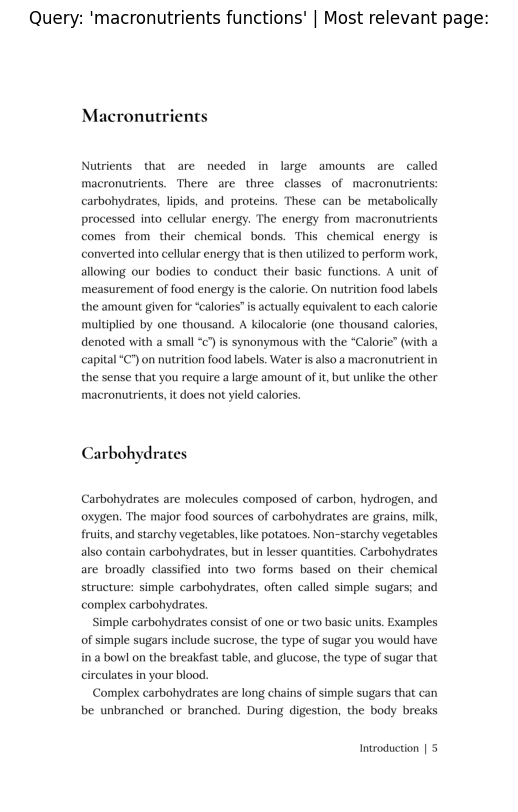

In [34]:
import fitz

# Open PDF and load target page
pdf_path = "human-nutrition-text.pdf" # requires PDF to be downloaded
doc = fitz.open(pdf_path)
page = doc.load_page(5 + 41) # number of page (our doc starts page numbers on page 41)

# Get the image of the page
img = page.get_pixmap(dpi=300)

# Optional: save the image
#img.save("output_filename.png")
doc.close()

# Convert the Pixmap to a numpy array
img_array = np.frombuffer(img.samples_mv,
                          dtype=np.uint8).reshape((img.h, img.w, img.n))

# Display the image using Matplotlib
import matplotlib.pyplot as plt
plt.figure(figsize=(13, 10))
plt.imshow(img_array)
plt.title(f"Query: '{query}' | Most relevant page:")
plt.axis('off') # Turn off axis
plt.show()

In [35]:
def dot_product(vector1, vector2):
    return torch.dot(vector1, vector2)

def cosine_similarity(vector1, vector2):
    dot_product = torch.dot(vector1, vector2)

    # Get Euclidean/L2 norm of each vector (removes the magnitude, keeps direction)
    norm_vector1 = torch.sqrt(torch.sum(vector1**2))
    norm_vector2 = torch.sqrt(torch.sum(vector2**2))

    return dot_product / (norm_vector1 * norm_vector2)

Functionizing the semantic search pipeline



In [36]:
def retrieve_relevant_resources(query: str,
                                embeddings: torch.tensor,
                                model: SentenceTransformer=embedding_model,
                                n_resources_to_return: int=5):
  # Embed the query
  query_embedding = model.encode(query, convert_to_tensor=True)
  # Get dot product scores on embeddings
  start_time = timer()
  dot_scores = util.dot_score(query_embedding, embeddings)[0]
  end_time = timer()
  print(f"[INFO] Time taken to get scores on {len(embeddings)} embeddings: {end_time-start_time} seconds.")
  scores, indices = torch.topk(input=dot_scores, k=n_resources_to_return)
  return scores, indices

def print_top_results_and_scores(query: str,
                                 embeddings: torch.tensor,
                                 pages_and_chunks: list[dict]=pages_and_chunks,
                                 n_resources_to_return: int=5):
  scores, indices = retrieve_relevant_resources(query=query,
                                                embeddings=embeddings,
                                                n_resources_to_return=n_resources_to_return)
  print(f"Query: {query}\n")
  print("Results:")
  for score, index in zip(scores, indices):
    print(f"Score: {score:.4f}")
    # Print relevant sentence chunk (since the scores are in descending order, the most relevant chunk will be first)
    print_wrapped(pages_and_chunks[index]["text"])
    # Print the page number too so we can reference the textbook further and check the results
    print(f"Page number: {pages_and_chunks[index]['page_number']}")
    print("\n")

In [37]:
query = "symptoms of pellagra"
scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

# Print out the texts of the top scores
print_top_results_and_scores(query=query,embeddings=embeddings)

[INFO] Time taken to get scores on 1680 embeddings: 7.865600014156371e-05 seconds.
[INFO] Time taken to get scores on 1680 embeddings: 5.781900017609587e-05 seconds.
Query: symptoms of pellagra

Results:
Score: 0.5000
Niacin deficiency is commonly known as pellagra and the symptoms include
fatigue, decreased appetite, and indigestion.  These symptoms are then commonly
followed by the four D’s: diarrhea, dermatitis, dementia, and sometimes death.
Figure 9.12  Conversion of Tryptophan to Niacin Water-Soluble Vitamins | 565
Page number: 565


Score: 0.3741
car. Does it drive faster with a half-tank of gas or a full one?It does not
matter; the car drives just as fast as long as it has gas. Similarly, depletion
of B vitamins will cause problems in energy metabolism, but having more than is
required to run metabolism does not speed it up. Buyers of B-vitamin supplements
beware; B vitamins are not stored in the body and all excess will be flushed
down the toilet along with the extra money spe

Getting an LLM for local generation

In [38]:
import torch
gpu_memory_size = torch.cuda.get_device_properties(0).total_memory
print(f"GPU memory size: {gpu_memory_size} bytes")

GPU memory size: 15835660288 bytes


In [42]:
model_id = "meta-llama/Meta-Llama-3.1-8B-Instruct"
use_quantization_config = True

from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers.utils import is_flash_attn_2_available

quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

if (is_flash_attn_2_available()) and (torch.cuda.get_device_capability(0)[0] >= 8):
  attn_implementation = "flash_attention_2"
else:
  attn_implementation = "sdpa"

tokenizer = AutoTokenizer.from_pretrained(model_id)

model = AutoModelForCausalLM.from_pretrained(pretrained_model_name_or_path=model_id,
                                             torch_dtype=torch.float16,
                                             quantization_config=quantization_config,
                                             attn_implementation=attn_implementation,
                                            #  device_map="auto"
                                             )
# Set to device
#model.to(device) #Don't need to set model to device as loading in 4 or 8 bit automatically do so so if I set to cuda twice it will caused error (can't move model accross gpu, like can't move model twice)

`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
def check_device(model):
    return next(model.parameters()).device

device = check_device(model)
print(f"The model is on the {device} device.")

The model is on the cuda:0 device.


In [44]:
model

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): Ll

In [45]:
# Get no of params
def get_model_num_params(model: torch.nn.Module):
    return sum([param.numel() for param in model.parameters()])

get_model_num_params(model)

4540600320

Generate text wih LLM

In [46]:
input_text = "What are the macronutrients, and what roles do they play in the human body?"
print(f"Input text:\n{input_text}")

# Create prompt template for instruction-tuned model
dialogue_template = [
    {"role": "user",
     "content": input_text}
]

# Apply the chat template
prompt = tokenizer.apply_chat_template(conversation=dialogue_template,
                                       tokenize=False, # keep as raw text (not tokenized)
                                       add_generation_prompt=True)
print(f"\nPrompt (formatted):\n{prompt}")

Input text:
What are the macronutrients, and what roles do they play in the human body?

Prompt (formatted):
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

What are the macronutrients, and what roles do they play in the human body?<|eot_id|><|start_header_id|>assistant<|end_header_id|>




In [47]:
# Generation without RAG
%%time

# Tokenize the input text (turn it into numbers) and send it to GPU
input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
print(f"Model input (tokenized):\n{input_ids}\n")

# Generate outputs passed on the tokenized input
outputs = model.generate(**input_ids,
                             max_new_tokens=256) # define the maximum number of new tokens to create
print(f"Model output (tokens):\n{outputs[0]}\n")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Model input (tokenized):
{'input_ids': tensor([[128000, 128000, 128006,    882, 128007,    271,   3923,    527,    279,
           9155,   2298,    332,  32930,     11,    323,   1148,  13073,    656,
            814,   1514,    304,    279,   3823,   2547,     30, 128009, 128006,
          78191, 128007,    271]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1]], device='cuda:0')}

Model output (tokens):
tensor([128000, 128000, 128006,    882, 128007,    271,   3923,    527,    279,
          9155,   2298,    332,  32930,     11,    323,   1148,  13073,    656,
           814,   1514,    304,    279,   3823,   2547,     30, 128009, 128006,
         78191, 128007,    271,    791,   2380,   1925,   9155,   2298,    332,
         32930,    527,  62345,     11,  28896,     11,    323,  50127,     13,
          9062,  11335,    264,  16595,   3560,    304,    279,   3823,   2547,
            11,

In [48]:
# Decode the output tokens to text
outputs_decoded = tokenizer.decode(outputs[0])
print(f"Model output (decoded):\n{outputs_decoded}\n")

Model output (decoded):
<|begin_of_text|><|begin_of_text|><|start_header_id|>user<|end_header_id|>

What are the macronutrients, and what roles do they play in the human body?<|eot_id|><|start_header_id|>assistant<|end_header_id|>

The three main macronutrients are carbohydrates, proteins, and fats. Each plays a vital role in the human body, providing energy, structure, and other essential functions.

### Carbohydrates

Carbohydrates are the body's primary source of energy. They are broken down into glucose, which is then absorbed into the bloodstream and transported to cells for energy production. The body uses glucose as the primary fuel for the brain, heart, and muscles.

There are two main types of carbohydrates:
- **Simple carbohydrates** (sugars) are quickly broken down and absorbed by the body, providing a rapid increase in blood sugar levels. Examples include table sugar, honey, and fruit.
- **Complex carbohydrates** (starches) are broken down more slowly, providing a sustained

In [49]:
query_list = [
    "What are the macronutrients, and what roles do they play in the human body?",
    "How do vitamins and minerals differ in their roles and importance for health?",
    "Describe the process of digestion and absorption of nutrients in the human body.",
    "What role does fibre play in digestion? Name five fibre containing foods.",
    "Explain the concept of energy balance and its importance in weight management.",
    "How often should infants be breastfed?",
    "What are symptoms of pellagra?",
    "How does saliva help with digestion?",
    "What is the RDI for protein per day?",
    "water soluble vitamins"
]

In [50]:
# Use RAG to find related data chunks

In [51]:
import random
query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

Query: How do vitamins and minerals differ in their roles and importance for health?
[INFO] Time taken to get scores on 1680 embeddings: 0.0001274040000680543 seconds.


(tensor([0.6322, 0.6220, 0.6187, 0.6178, 0.6128], device='cuda:0'),
 tensor([ 51,  47, 874,  41, 927], device='cuda:0'))

In [56]:
def prompt_formatter(query: str, context_items: list[dict]) -> str:
  context = "- " + "\n- ".join([item["text"] for item in context_items])

  base_prompt = """Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.
\nExample 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an antioxidant, protecting cells from damage. Vitamin K is essential for blood clotting and bone metabolism.
\nExample 2:
Query: What are the causes of type 2 diabetes?
Answer: Type 2 diabetes is often associated with overnutrition, particularly the overconsumption of calories leading to obesity. Factors include a diet high in refined sugars and saturated fats, which can lead to insulin resistance, a condition where the body's cells do not respond effectively to insulin. Over time, the pancreas cannot produce enough insulin to manage blood sugar levels, resulting in type 2 diabetes. Additionally, excessive caloric intake without sufficient physical activity exacerbates the risk by promoting weight gain and fat accumulation, particularly around the abdomen, further contributing to insulin resistance.
\nExample 3:
Query: What is the importance of hydration for physical performance?
Answer: Hydration is crucial for physical performance because water plays key roles in maintaining blood volume, regulating body temperature, and ensuring the transport of nutrients and oxygen to cells. Adequate hydration is essential for optimal muscle function, endurance, and recovery. Dehydration can lead to decreased performance, fatigue, and increased risk of heat-related illnesses, such as heat stroke. Drinking sufficient water before, during, and after exercise helps ensure peak physical performance and recovery.
\nNow use the following context items to answer the user query:
{context}
\nRelevant passages: <extract relevant passages from the context here>
User query: {query}
Answer:"""

  base_prompt = base_prompt.format(context=context, query=query)

  dialogue_template = [
      {"role": "user",
       "content": base_prompt}
  ]

  prompt = tokenizer.apply_chat_template(conversation=dialogue_template, tokenize=False, add_generation_prompt=True)

  return prompt

In [57]:
query = random.choice(query_list)
print(f"Query: {query}")

scores, indices = retrieve_relevant_resources(query=query, embeddings=embeddings)
scores, indices

context_items = [pages_and_chunks[i] for i in indices]

prompt = prompt_formatter(query=query, context_items=context_items)
print(prompt)

Query: What are the macronutrients, and what roles do they play in the human body?
[INFO] Time taken to get scores on 1680 embeddings: 6.645900020885165e-05 seconds.
<|begin_of_text|><|start_header_id|>user<|end_header_id|>

Based on the following context items, please answer the query.
Give yourself room to think by extracting relevant passages from the context before answering the query.
Don't return the thinking, only return the answer.
Make sure your answers are as explanatory as possible.
Use the following examples as reference for the ideal answer style.

Example 1:
Query: What are the fat-soluble vitamins?
Answer: The fat-soluble vitamins include Vitamin A, Vitamin D, Vitamin E, and Vitamin K. These vitamins are absorbed along with fats in the diet and can be stored in the body's fatty tissue and liver for later use. Vitamin A is important for vision, immune function, and skin health. Vitamin D plays a critical role in calcium absorption and bone health. Vitamin E acts as an ant

In [58]:
# Now we pass this into LLM
input_ids = tokenizer(prompt, return_tensors="pt").to(device)

outputs = model.generate(**input_ids, max_new_tokens=256)
outputs_decoded = tokenizer.decode(outputs[0])

print(f"Query: {query}")
print(f"Answer: {outputs_decoded.replace(prompt, '')}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


Query: What are the macronutrients, and what roles do they play in the human body?
Answer: <|begin_of_text|>The macronutrients are carbohydrates, lipids, proteins, and water. These nutrients are required in large amounts and play crucial roles in the human body.

Carbohydrates provide a ready source of energy for the body and provide structural constituents for the formation of cells. 

Lipids provide stored energy for the body, functions as structural components of cells, and also as signaling molecules for proper cellular communication. It provides insulation to vital organs and works to maintain body temperature.

Proteins provide structure to bones, muscles, and skin, and play a role in conducting most of the chemical reactions that take place in the body. They also provide four kilocalories of energy per gram.

Water transports essential nutrients to all body parts, transports waste products for disposal, and aids with body temperature maintenance.<|eot_id|>


We can also return the context as well

In [67]:
# def generate_with_context_print_out(query, temperature=0.7, max_new_tokens=512):
#   scores, indices = retrieve_relevant_resources(query, embeddings)

#   context_items = [pages_and_chunks[i] for i in indices]

#   prompt = prompt_formatter(query, context_items)

#   input_ids = tokenizer(prompt, return_tensors="pt").to(device)

#   output = model.generate(**input_ids, temperature=temperature, max_new_tokens=max_new_tokens)

#   output_decoded = tokenizer.decode(output)

#   return output_decoded.replace(prompt, ''), context_items

In [68]:
# query = random.choice(query_list)
# print(f"Query: {query}")

# # Answer query with context and return context
# answer, context_items = generate_with_context_print_out(query=query, temperature=0.7, max_new_tokens=512)

# print(f"Answer:\n")
# print_wrapped(answer)
# print(f"Context items:")
# context_items